# Can We Predict Who Will Show for Interviews

I've been looking for a small data set to practice some machine learning techniques I've picked up in the fastai machine learning [course](http://course.fast.ai/). Specifically, the machine learning course goes into a lot of detail on random forest methods and how to go about interpreting and tuning them. So without further ado, let's dive into this new data set and see what we can do.

#### Package loading

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics

## Data Import and Cleaning

My data for this comes from kaggle. It's a user submitted [data set](https://www.kaggle.com/vishnusraghavan/the-interview-attendance-problem/data), not a competition set, so there's no prize money, but there's a lot of opportunity for exploration.

In [3]:
#PATH = "data/"

In [4]:
#!ls {PATH}

I can read it in with pandas and take a look at the first couple rows to get a sense of what I am working with.

In [5]:
# Read in the data
#df_raw = pd.read_csv(f'{PATH}Interview.csv', parse_dates = ['Date of Interview'])

#Alt read in for Kaggle kernal
df_raw = pd.read_csv('../input/Interview.csv')

In [6]:
df_raw.head()

,Date of Interview,Client name,Industry,Location,Position to be closed,Nature of Skillset,Interview Type,Name(Cand ID),Gender,Candidate Current Location,...,Are you clear with the venue details and the landmark.,Has the call letter been shared,Expected Attendance,Observed Attendance,Marital Status,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 1,Male,Chennai,...,Yes,Yes,Yes,No,Single,NaN,NaN,NaN,NaN,NaN
1,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 2,Male,Chennai,...,Yes,Yes,Yes,No,Single,NaN,NaN,NaN,NaN,NaN
2,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 3,Male,Chennai,...,NaN,NaN,Uncertain,No,Single,NaN,NaN,NaN,NaN,NaN
3,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 4,Male,Chennai,...,Yes,Yes,Uncertain,No,Single,NaN,NaN,NaN,NaN,NaN
4,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 5,Male,Chennai,...,Yes,Yes,Uncertain,No,Married,NaN,NaN,NaN,NaN,NaN


First thing I notice is that we have 5 unnamed, nan filled columns. I'm guessing this is related to how the csv file was created, but regardless we aren't going to want those empty columns, so let's get rid of them straight away.

Second, the column names are kind of absurdly long. Let's go ahead and clean those up just to make subsequent data manipulation have a little less typing.

In [7]:
# Removing empty variables
# I'll go ahead and put all this work in a new df so I have an original copy if I need to go back for any reason.
interview_df = df_raw.drop(['Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27'], axis = 1)

# Renaming variables to strings that are a little easier to work with.
interview_df.columns = ['Date', 'Client', 'Industry', 'Location', 'Position', 'Skillset',
                        'Interview_Type', 'ID', 'Gender', 'Cand_Loc', 'Job_Loc', 'Venue',
                        'Native_Loc', 'Permission', 'Hope', 'Three_hour_call', 'Alt_phone',
                        'Resume_Printout', 'Clarify_Venue', 'Shared_Letter', 'Expected', 
                        'Attended', 'Martial_Status']
interview_df.shape

(1234, 23)

This leaves us with a relatively small data frame, so initially I assumed this was going to be pretty straightforward. Maybe a little cleaning of the data and then straight into building some random forests. For good measure though I decided to loop through all the variables and just take a quick look at the unique values in each variable. This can give you a good idea of what sort of cleaning is going to be necessary. It's not a great thing to do on an enormous data set, perhaps, but for something this small it's very quick to do.

In [8]:
for c in interview_df.columns:
    print(c)
    print(interview_df[c].unique())

Date
['13.02.2015' '19.06.2015' '23.06.2015' '29.06.2015' '25.06.2015' '25.05.16' '25.5.2016' '25-05-2016'
 '25.05.2016' '25-5-2016' '04/12/16' '13.04.2016' '27.02.2016' '07.05.2016' '5.5.16' '4.5.16' '21.4.16'
 '22.4.16' '23.4.16' '15 Apr 16' '19 Apr 16' '20 Apr 16' '21-Apr -16' '22 -Apr -16' '25 – Apr-16' '25 Apr 16'
 '18 Apr 16' '11.5.16' '10.5.16' '11.05.16' '12.04.2016' '12.04.2017' '12.04.2018' '12.04.2019' '12.04.2020'
 '12.04.2021' '12.04.2022' '12.04.2023' '8.5.16' '7.5.16' '19.03.16' '24.05.2016' '05/11/2016' '26/05/2016'
 '10.05.2016' '28.08.2016 & 09.00 AM' '28.08.2016 & 9.30 AM' '28.8.2016 & 12.00 PM' '28.08.2016 & 09.30 AM'
 '28.8.2016 & 10.30 AM' '28.8.2016 & 09.30 AM' '28.8.2016 & 04.00 PM' '28.08.2016 & 11.30 AM'
 '28.08.2016 & 11.00 AM' '28.08.2016 & 10.30 AM' '28.8.2016 & 03.00 PM' '28.08.2016 & 10.00 AM'
 '28.8.2016 & 02.00 PM' '28.8.2016 & 11.00 AM' '13.06.2016' '02.09.2016' '02.12.2015' '23.02.2016'
 '22.03.2016' '26.02.2016' '06.02.2016' '21.4.2016' '21/04/16' '2

Oh boy! Maybe this isn't going to be so quick after all. Pretty much every variable is encoded in an inconsistent manner. Dates are separated by /, ., - just to name a few. Sometimes there is a time tacked onto the date as well. Skillset is similarly a mess. It looks like some rows have multiple skills (with various separators, of course) and some rows have times in them for some reason.

There are also going to be a lot of judgment calls on how to clean this up. For instance, in the Interview_Type column, is 'scheduled walk in' actually different from a 'walk in'? Similar decisions are going to have to be made on Shared_Letter, Resume_Printout, etc. Basically, though this data set is tiny, it's going to require a ton of cleaning.  I guess I should dive in.

I'm starting with the Date variable, so I wanted to print out it's unique values to see what I was working with a little more clearly. It looks like I will need to get rid of a bunch of whitespace, decide on a separator for the date and convert all the inconsistent ones and then remove some random times that made it into the fray.  This actually took a little bit of experimenting to get right, but I think the below does a good--though very hackish--job of cleaning up the dates.

In [9]:
print(interview_df['Date'].unique())

['13.02.2015' '19.06.2015' '23.06.2015' '29.06.2015' '25.06.2015' '25.05.16' '25.5.2016' '25-05-2016'
 '25.05.2016' '25-5-2016' '04/12/16' '13.04.2016' '27.02.2016' '07.05.2016' '5.5.16' '4.5.16' '21.4.16'
 '22.4.16' '23.4.16' '15 Apr 16' '19 Apr 16' '20 Apr 16' '21-Apr -16' '22 -Apr -16' '25 – Apr-16' '25 Apr 16'
 '18 Apr 16' '11.5.16' '10.5.16' '11.05.16' '12.04.2016' '12.04.2017' '12.04.2018' '12.04.2019' '12.04.2020'
 '12.04.2021' '12.04.2022' '12.04.2023' '8.5.16' '7.5.16' '19.03.16' '24.05.2016' '05/11/2016' '26/05/2016'
 '10.05.2016' '28.08.2016 & 09.00 AM' '28.08.2016 & 9.30 AM' '28.8.2016 & 12.00 PM' '28.08.2016 & 09.30 AM'
 '28.8.2016 & 10.30 AM' '28.8.2016 & 09.30 AM' '28.8.2016 & 04.00 PM' '28.08.2016 & 11.30 AM'
 '28.08.2016 & 11.00 AM' '28.08.2016 & 10.30 AM' '28.8.2016 & 03.00 PM' '28.08.2016 & 10.00 AM'
 '28.8.2016 & 02.00 PM' '28.8.2016 & 11.00 AM' '13.06.2016' '02.09.2016' '02.12.2015' '23.02.2016'
 '22.03.2016' '26.02.2016' '06.02.2016' '21.4.2016' '21/04/16' '21.4.1

In [10]:
def clean_date(date):
    date = date.str.strip()
    date = date.str.split("&").str[0]
    date = date.str.replace('–', '/')
    date = date.str.replace('.', '/')
    date = date.str.replace('Apr', '04')
    date = date.str.replace('-', '/')
    date = date.str.replace(' ', '/')
    date = date.str.replace('//+', '/')
    return date

In [11]:
interview_df['Date'] = clean_date(interview_df['Date'])
print(interview_df['Date'].unique())

['13/02/2015' '19/06/2015' '23/06/2015' '29/06/2015' '25/06/2015' '25/05/16' '25/5/2016' '25/05/2016'
 '04/12/16' '13/04/2016' '27/02/2016' '07/05/2016' '5/5/16' '4/5/16' '21/4/16' '22/4/16' '23/4/16' '15/04/16'
 '19/04/16' '20/04/16' '21/04/16' '22/04/16' '25/04/16' '18/04/16' '11/5/16' '10/5/16' '11/05/16'
 '12/04/2016' '12/04/2017' '12/04/2018' '12/04/2019' '12/04/2020' '12/04/2021' '12/04/2022' '12/04/2023'
 '8/5/16' '7/5/16' '19/03/16' '24/05/2016' '05/11/2016' '26/05/2016' '10/05/2016' '28/08/2016/' '28/8/2016/'
 '13/06/2016' '02/09/2016' '02/12/2015' '23/02/2016' '22/03/2016' '26/02/2016' '06/02/2016' '21/4/2016'
 '21/4/15' '22/01/2016' '3/6/16' '03/06/16' '09/01/2016' '03/04/2015' '13/03/2015' '17/03/2015' '18/03/2014'
 '4/04/15' '16/04/2015' '17/04/2015' '9/04/2015' '05/02/15' '30/05/2016' '07/06/2016' '20/08/2016'
 '14/01/2016' '30/1/16' '30/01/2016' '30/01/16' '30/1/2016' '06/05/2016' nan]


So this little function took care of most of the cleaning, but I still had a stubborn issue where some years where formatted in 2 digit format and some were in 4 digit. As far as I'm aware, pandas can't deal with that, so I had to fix this. In another hackish fix, I decided to split the new Date column into a month, day and year column. From there I could fix the year formats and then I can group them back together in a new Date column. I'm 100% sure this was not the best way to handle this, so I'd love to hear how you would do it. But at the end of the day, it worked and I didn't want to waste more time figuring out the 'correct' solution.

In [12]:
# Through exploration I discovered row 1233 had a ton of missign values, including the date. Since I can't parse 
# a missing date (and I'm going to create a bunch of new features from that date variable) I'm just removing the row
interview_df.drop(interview_df.index[[1233]], inplace = True)

In [13]:
# Create my new date variables
interview_df['year'] = interview_df['Date'].str.split("/").str[2]
interview_df['day'] = interview_df['Date'].str.split("/").str[0]
interview_df['month'] = interview_df['Date'].str.split("/").str[1]

# This will find the short years and replace with long years
interview_df['year'].replace(['16', '15'], ['2016', '2015'], inplace = True)

# Finally I create the new Date column
interview_df['date'] = pd.to_datetime(pd.DataFrame({'year': interview_df['year'],
                                            'month': interview_df['month'],
                                            'day': interview_df['day']}), format = '%Y-%m-%d')
interview_df.head()

,Date,Client,Industry,Location,Position,Skillset,Interview_Type,ID,Gender,Cand_Loc,...,Resume_Printout,Clarify_Venue,Shared_Letter,Expected,Attended,Martial_Status,year,day,month,date
0,13/02/2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 1,Male,Chennai,...,Yes,Yes,Yes,Yes,No,Single,2015,13,02,2015-02-13
1,13/02/2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 2,Male,Chennai,...,Yes,Yes,Yes,Yes,No,Single,2015,13,02,2015-02-13
2,13/02/2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 3,Male,Chennai,...,NaN,NaN,NaN,Uncertain,No,Single,2015,13,02,2015-02-13
3,13/02/2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 4,Male,Chennai,...,No,Yes,Yes,Uncertain,No,Single,2015,13,02,2015-02-13
4,13/02/2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 5,Male,Chennai,...,Yes,Yes,Yes,Uncertain,No,Married,2015,13,02,2015-02-13


That seems to have worked out just fine, so I can drop the old Date column and my temporary year, month, day columns.

In [14]:
interview_df.drop(['Date', 'year', 'month', 'day'], axis = 1, inplace = True)

Onward to the next messy variable. Personally I find lower case a bit easy to read, so first I will lowercase all the data. It's probably a good idea to strip whitespace from everything up front too.

In [15]:
interview_df = pd.concat([interview_df[c].astype(str).str.lower() for c in interview_df.columns], axis = 1)
interview_df = pd.concat([interview_df[c].astype(str).str.strip() for c in interview_df.columns], axis = 1)

Looking at the next variable, Client, it's pretty unclear whether entries 'standard chartered bank' and 'standard chartered bank chennai' are the same client. Several entries are like that. Just thinking ahead, I took a look at how often each of these clients occurs in the data. 

In [16]:
interview_df['Client'].value_counts()

standard chartered bank            904
hospira                             75
pfizer                              75
aon hewitt                          28
flextronics                         23
anz                                 22
hewitt                              20
ust                                 18
prodapt                             17
standard chartered bank chennai     17
astrazeneca                         15
williams lea                        11
barclays                             5
aon hewitt gurgaon                   2
woori bank                           1
Name: Client, dtype: int64

So this is really unbalanced by Client. I have a strong suspicion the similar clients are just different encodings of the same Client name. It's easy enough to find and replace these alternate values with the 'default' value. It's certainly possible that these values are actually different clients, but for now I'll go with grouping up the ones that seem like the same company.

In [17]:
interview_df['Client'].replace(['standard chartered bank chennai', 'aon hewitt gurgaon', 'hewitt'], 
                              ['standard chartered bank', 'aon hewitt', 'aon hewitt'], inplace = True)

There's quite a few variables with similar issues, so I'll just do all their cleaning here.

In [18]:
interview_df['Industry'].replace(['it products and services', 'it services'], 
                              ['it', 'it'], inplace = True)

interview_df['Location'].replace(['- cochin-'], 
                              ['cochin'], inplace = True)

# I'm really not sure about this Interview_Type variable. I'd ask if given the chance. For now I'm just going
# to use 'scheduled walkin', 'walkin' and 'scheduled'
interview_df['Interview_Type'].replace(['scheduled walk in', 'sceduled walkin'],
                                       ['scheduled walkin', 'scheduled walkin'], inplace = True)
# I wonder why  cochin is always messed up?
interview_df['Cand_Loc'].replace(['- cochin-'], 
                              ['cochin'], inplace = True)
interview_df['Job_Loc'].replace(['- cochin-'], 
                              ['cochin'], inplace = True)
interview_df['Venue'].replace(['- cochin-'], 
                              ['cochin'], inplace = True)
# I'm assuming all these native locations are actual places. I didn't check them all
interview_df['Native_Loc'].replace(['- cochin-'], 
                              ['cochin'], inplace = True)
# I don't know if nan's and 'not yet' are actually different, but I'm treating them like they are
interview_df['Permission'].replace(['na', 'not yet', 'yet to confirm'], 
                              ['nan', 'tbd', 'tbd'], inplace = True)
interview_df['Hope'].replace(['na', 'not sure', 'cant say'], 
                              ['nan', 'unsure', 'unsure'], inplace = True)
interview_df['Three_hour_call'].replace(['na', 'no dont'], 
                              ['nan', 'no'], inplace = True)
interview_df['Hope'].replace(['na', 'not sure', 'cant say'], 
                              ['nan', 'unsure', 'unsure'], inplace = True)
interview_df['Alt_phone'].replace(['na', 'no i have only thi number'], 
                              ['nan', 'no'], inplace = True)
interview_df['Resume_Printout'].replace(['na', 'not yet', 'no- will take it soon'], 
                              ['nan', 'ny', 'ny'], inplace = True)
interview_df['Clarify_Venue'].replace(['na', 'no- i need to check'], 
                              ['nan', 'no'], inplace = True)
interview_df['Shared_Letter'].replace(['na', 'not sure', 'need to check', 'not yet', 'yet to check',
                                       'havent checked'],
                                      ['nan', 'unsure', 'unsure', 'unsure', 'unsure', 'unsure'], inplace = True)
interview_df['Expected'].replace(['na', '11:00 am', '10.30 am'], 
                              ['nan', 'nan', 'nan'], inplace = True)
interview_df['Attended'].replace(['yes', 'no'],
                                 [1, 0], inplace = True)

Now the last column, which I think is probably the most difficult- Skillset. There's all sorts of variation in terms of what's even in the column, and after we figure out how to standardize that, we need to spread the column out into multiple skill columns. On top of that, it's not clear from the original data set whether this is the applicants skillset or the skillset that the employer is looking for. I have my doubts as to whether skillset is 
going to be that useful in the model. Since there are ~100 unique values of Skillset and cleaning will involve working through all of them, I'm going to see how well I can do without Skillset first.

In [19]:
modeling_df = interview_df.drop(['Skillset'], axis = 1)

Looking through this data set, I noticed that there were a handful of dates that were from the future (think >2019). I'm assuming these are miscoded and I'm going to remove them.

In [20]:
modeling_df = modeling_df[modeling_df['date'] < '2018-01-01']

Just a couple more tweaks before we can actually start to build some models. First, I want to extract date information from my date variable. Date contains a ton of useful information -- day of week, weekday/weekend, month, year, start of month, etc-- but much of it is hidden. Fastai actually has a method for extracting this information from a datetime variable, so we'll use it here.

In [21]:
add_datepart(modeling_df, 'date')

In [22]:
modeling_df.columns

Index(['Client', 'Industry', 'Location', 'Position', 'Interview_Type', 'ID',
       'Gender', 'Cand_Loc', 'Job_Loc', 'Venue', 'Native_Loc', 'Permission',
       'Hope', 'Three_hour_call', 'Alt_phone', 'Resume_Printout',
       'Clarify_Venue', 'Shared_Letter', 'Expected', 'Attended',
       'Martial_Status', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
       'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype='object')

So I now have 13 date related variables that I was able to create from the date function. The second thing I need to do is take all the categorical variables and convert them from their string format into something the random forest model can use. This is really easy with the fastai library.

In [23]:
# Handling categorical variables
train_cats(modeling_df)

I want to take a quick look at the data now that I've done all my cleaning. I need to change the amount of data frame pandas  will display, but that's a simple fix with the function below.

In [24]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

In [25]:
display_all(modeling_df.tail().T)

,1228,1229,1230,1231,1232
Client,pfizer,pfizer,pfizer,pfizer,pfizer
Industry,pharmaceuticals,pharmaceuticals,pharmaceuticals,pharmaceuticals,pharmaceuticals
Location,chennai,chennai,chennai,chennai,chennai
Position,niche,niche,niche,niche,niche
Interview_Type,scheduled,scheduled,scheduled,scheduled,scheduled
ID,candidate 1229,candidate 1230,candidate 1231,candidate 1232,candidate 1233
Gender,male,male,male,male,female
Cand_Loc,chennai,chennai,chennai,chennai,chennai
Job_Loc,chennai,chennai,chennai,chennai,chennai
Venue,chennai,chennai,chennai,chennai,chennai


Congrats! Our data is basically in a usable form now. Note that in 'Attended' 1 is representing Yes and 0 No. The rest is pretty clear--at least in my opinion (after looking at it while doing all the cleaning).

## Pre-processing 

Since this data set didn't have a test set included, I need to create my own. It would be nice to split into a train, validation and test set, but since the data set is so small to begin with --and the fact that this is just exploration--I'm just going to split into a training and validation set. I'll set aside 20% of the data to be used for validation. I'm also going to split the dependent variable into it's own data frame just for convenience. Note that proc_df is also going to convert all the categorical variables into numeric values to use in the model.

In [27]:
df, y, nas = proc_df(modeling_df, "Attended")

In [28]:
display_all(df.tail().T)

,1228,1229,1230,1231,1232
Client,7,7,7,7,7
Industry,4,4,4,4,4
Location,2,2,2,2,2
Position,3,3,3,3,3
Interview_Type,1,1,1,1,1
ID,257,259,260,261,262
Gender,2,2,2,2,1
Cand_Loc,2,2,2,2,2
Job_Loc,2,2,2,2,2
Venue,2,2,2,2,2


In [29]:
display_all(y.T)

array([0, 0, 0, ..., 1, 1, 1])

This will give me about 1000 rows of data to train with and ~250 for validation. With such a small data set, I expect there could be some slight variation between different versions of the same model. If you think about it, a change in the assignment of just 1 or 2 rows will make a relatively big difference when we only have 1000 data points versus when we are building models on data sets with millions of rows.  Once all my modeling is finished, I will rerun the model with all the same parameters using all the data. Obviously I won't be able to test it on anything, but using the out-of-bag score should give me some idea of how the model does with a little bit more data.

Regardless, even with a small data set like this, it's critical to have a validation setup. As we'll see in just a minute, it's incredibly easy to overfit and think your model is performing great only to be bitten when you put the model into production and it doesn't generalize to new data at all.

In [30]:
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

In [31]:
n_valid = int(len(modeling_df) * .2)
n_trn = len(modeling_df) - n_valid
raw_train, raw_valid = split_vals(modeling_df, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

## Modeling

### Base Model

Now that I have clean data and a validation setup, I can actually start to explore models. First, I want to build a random forest with all default parameters.

In [32]:
m_base = RandomForestClassifier(n_jobs = -1, oob_score=True)
%time m_base.fit(X_train, y_train)
print("Training Acc:", round(m_base.score(X_train, y_train),5)),
print("Validation Acc:", round(m_base.score(X_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m_base.oob_score_, 5))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


CPU times: user 43.1 ms, sys: 5.39 ms, total: 48.4 ms
Wall time: 135 ms
Training Acc: 0.97047
Validation Acc: 0.67347
Out-of-Bag Acc: 0.63951


This first model is just using all the defaults in sklearn's random forest classifier method. That means it will grow the tree till each node is as pure as possible. If we take a look at the resulting tree, we can see it's huge. 

In [33]:
probs = m_base.predict_proba(X_valid)
probs = [p[1] for p in probs]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, probs)
roc_auc = metrics.roc_auc_score(y_valid, probs)

Text(0,0.5,'True Positive Rate')

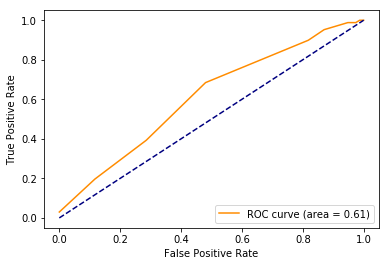

In [34]:
plt.plot(fpr, tpr, color = 'darkorange',
        label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

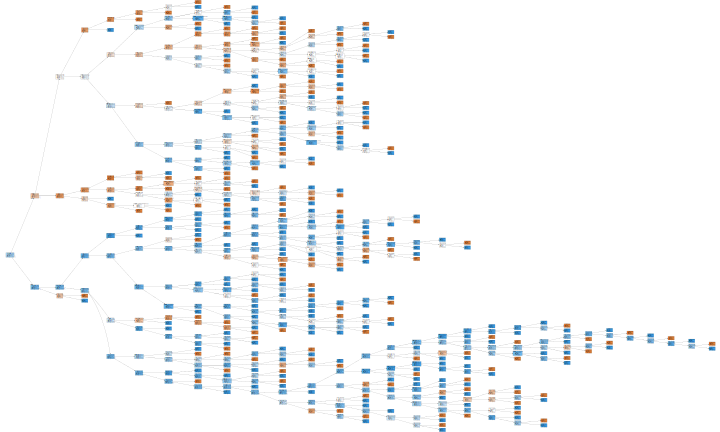

In [35]:
draw_tree(m_base.estimators_[0], df, precision = 3)

There is simply no way this tree didn't overfit, and when I look at the validation set accuracy I see that's the case. The model was 97% accurate on the training set, but only 64% on the validation set. That's a sure sign of overfitting. The first thing I should test is limiting the depth of the tree. 

In [36]:
m = RandomForestClassifier(min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Training Acc: 0.76986
Validation Acc: 0.69388
Out-of-Bag Acc: 0.68024


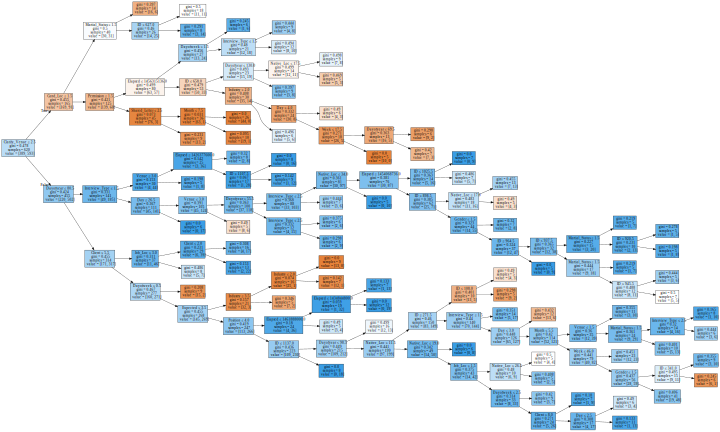

In [37]:
draw_tree(m.estimators_[0], df, precision = 3)

So while my training set accuracy went down dramatically, this model actually generalized better to the validation set. Setting min_samples_leaf tells the model that each node has to have at least 5 rows in it. This results in a simpler model, but one that should generalize better to new data.

Another lever to pull when tuning is max_features. This specifies what proportion of features(aka columns) to randomly select for each tree in the random forest. This has the effect of increasing the amount of variation per tree--after all, you trees are now being built with different features-- which will result in better generalization. The sklearn documentation has a couple suggestions for starting values and after tinkering with a bunch, I found 'log2' gave me the best performance and the most stable results. 

In [38]:
m = RandomForestClassifier(min_samples_leaf=5, max_features = 'log2',n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Training Acc: 0.77088
Validation Acc: 0.68163
Out-of-Bag Acc: 0.67719


I could also try subsampling to reduce over-fitting, but here the results were marginally worse, so I will stick with my adjusted tree parameters. Subsampling **is** really useful when we are working with a larger data set, however. You get the benefit of speeding up your computations *and* you reduce over-fitting at the same time by using a different random sample of data per tree.

So far, I've just used the tree building parameters available in the RandomForestClassifier method from sklearn to tune my tree and reduce over-fitting. I've looked at the number of trees in the forest, the depth of those trees, the size of the nodes of those trees and the number of features to random choose while building each tree.  Of those parameters, only the size of the nodes and the number of features in each tree had much effect in reducing over-fitting. With such a small data set, additional trees didn't seem to help much after about 8-10 trees--though that parameter is especially important to keep in your toolkit for larger data sets.

### Feature Importance

Tree depth and node size are important parameters, but they aren't the whole story. I can also adjust my model by looking at feature importance and removing unnecessary or redundant features. Perhaps more importantly, I can use these to gain an understanding of my problem. In this case, maybe there is a feature that is a clear signal someone will miss an interview. Identifying this feature could be more important that your full model in some cases.

To examine the importance of my features, I can use the rf_feat_importance function from the fastai library. Determining a features importance is actually pretty straightforward. Say I wanted to determine how important 'year' was to my model. I can take the values of the year column and randomly reshuffle them. In doing this, I create a variable that has no relationship to the dependent variable.  Now, if I run my data through the model again, I can see how much the performance decreases. This performance difference is the feature importance of the year variable. For a full list of feature importances, I just run through each feature in the model in the same manner.

In [39]:
feature_imp = rf_feat_importance(m, df)

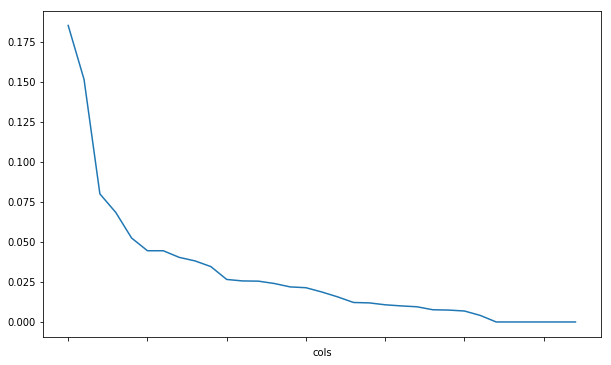

In [40]:
feature_imp.plot('cols', 'imp', figsize = (10, 6), legend = False)

It's clear from the plot above that the first two features explain a ton of the variance in the model. I can use a different view to see exactly what these features are.

In [41]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend = False)

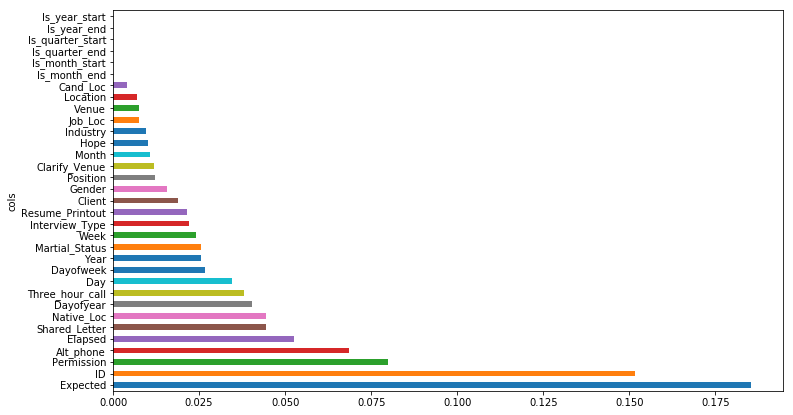

In [42]:
plot_fi(feature_imp)

So 'Expected' and 'ID' are the most important features by far. This is pretty worrying. The ID variable appears to just be a numeric ID of the individuals interviewing for jobs. Looking back at the original data set, the ID's are just assigned 1-1232 with no regard for date, so it's probably something that was assigned after the fact to anonymize the data. But, if this was assigned after the fact and is this important to the model, it makes me think we have some information leakage. Like perhaps the data was ordered in some way before this ID was assigned and that ordering had some relation to who actually attended interviews.  I'm not sure what exactly happened, but it's definitely concerning and is something I'd ask about if I were actually working with this data.

Expected could fall into the same trap. When was the expected variable assigned? Was it something after the fact? It could be that the screeners for these applicants did a good job in predicting who would attended, so the correlation between the expected and actual attendance was high. I can't really be sure for ID or Expected what is happening, but in this instance, I'm just going to leave them as is.

Looking at the other end of the importance plot, you can see that all the date variables related to starting or ending periods are essentially useless. I can remove all the variables below a certain threshold to tidy up our model.

In [43]:
keep = feature_imp[feature_imp.imp > 0.0075].cols

In [44]:
len(keep)

24

In [45]:
df_keep = df[keep].copy()

When I retrain the model with these features removed, I actually see a tiny bit of improvement. Simplifying your model not only makes it more interpretable, but it can improve it's generalization.

In [46]:
X_train, X_valid = split_vals(df_keep, n_trn)

In [47]:
m = RandomForestClassifier(min_samples_leaf = 5,
                           max_features='log2', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Training Acc: 0.76069
Validation Acc: 0.67755
Out-of-Bag Acc: 0.67719


In [48]:
fi = rf_feat_importance(m, df_keep)

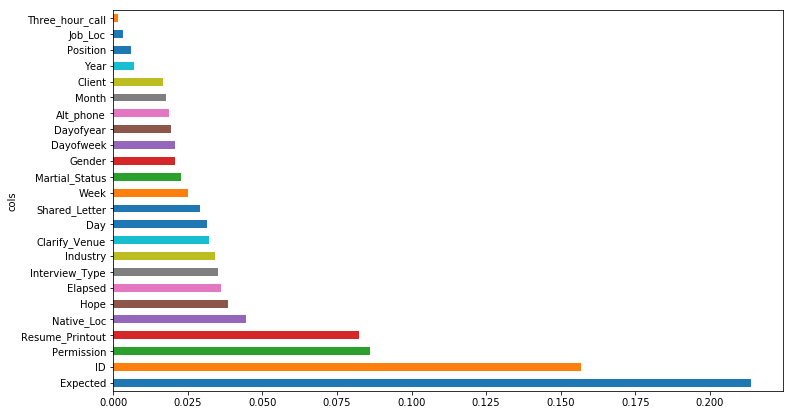

In [49]:
plot_fi(fi)

If you look at these features, they make a lot of sense. Whether the screener expected the applicant is quite predictive, as are whether the applicant shared their cover letter, an alternative phone number and their resume. These are all things that I would consider a sign of interest in a position and so doing them probably means you are interested in the job and more likely to show up for an interview.

### One-Hot Encoding

In [52]:
df_trn, y_trn, nas = proc_df(modeling_df, 'Attended', max_n_cat = 7)

In [56]:
?proc_df

Signature: proc_df(df, y_fld=None, skip_flds=None, do_scale=False, na_dict=None, preproc_fn=None, max_n_cat=None, subset=None, mapper=None)
Docstring:
proc_df takes a data frame df and splits off the response variable, and
changes the df into an entirely numeric dataframe.

Parameters:
-----------
df: The data frame you wish to process.

y_fld: The name of the response variable

skip_flds: A list of fields that dropped from df.

do_scale: Standardizes each column in df,Takes Boolean Values(True,False)

na_dict: a dictionary of na columns to add. Na columns are also added if there
    are any missing values.

preproc_fn: A function that gets applied to df.

max_n_cat: The maximum number of categories to break into dummy values, instead
    of integer codes.

subset: Takes a random subset of size subset from df.

mapper: If do_scale is set as True, the mapper variable
    calculates the values used for scaling of variables during training time(mean and standard deviation).

Returns:
----

In [57]:
X_train, X_valid = split_vals(df_trn, n_trn)

In [58]:
m = RandomForestClassifier(min_samples_leaf = 5,
                           max_features='log2', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Training Acc: 0.74847
Validation Acc: 0.69796
Out-of-Bag Acc: 0.68432


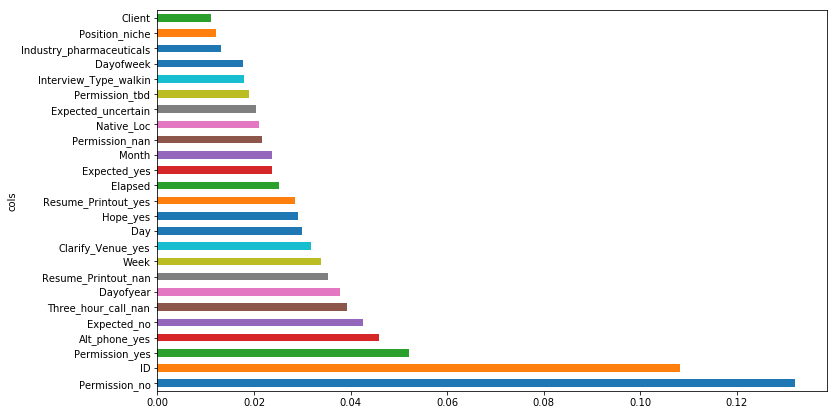

In [59]:
fi = rf_feat_importance(m, df_trn)
plot_fi(fi[:25])

### Removing Redundant features

Another useful technique for examining your model is dendrogram plots. These plots show the relation between features. The closer the split is to the right side of the plot, the more correlated the features are. In this case, features like Dayofyear and Week are highly correlated while features such as Client and Day are very uncorrelated.

In [60]:
from scipy.cluster import hierarchy as hc

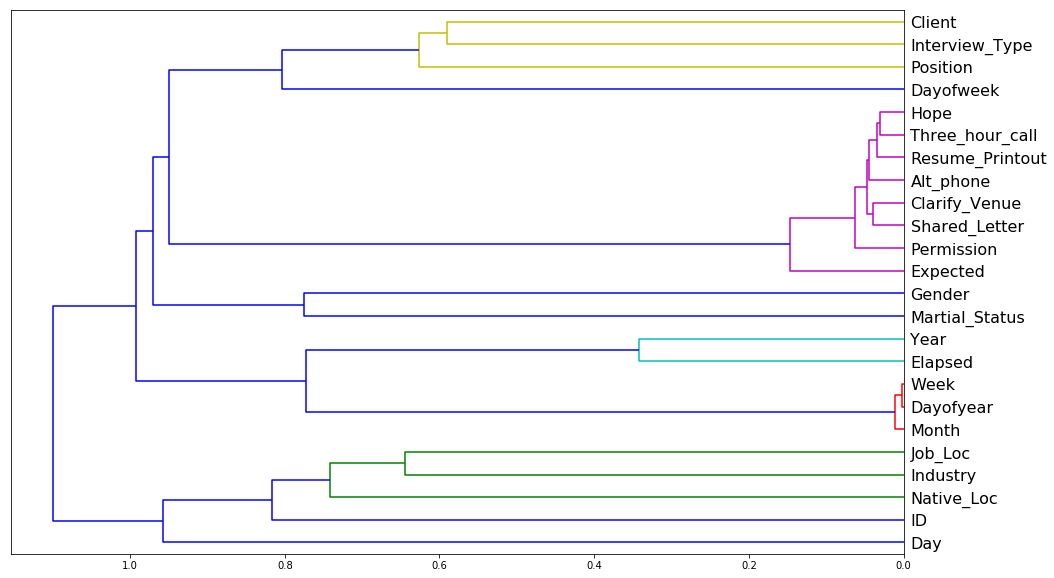

In [61]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation,4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method = 'average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels = df_keep.columns, orientation='left',
                          leaf_font_size =16)
plt.show()

You can use this information to improve your model. Since I see that Dayofyear and Week are highly correlated, why not look and see how my model performs if I remove one of the variables. That's precisely what I do below.

In [62]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=8, max_features='sqrt', n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [63]:
get_oob(df_keep)

0.6975560081466395

In [64]:
for c in ('Week', 'Dayofyear'):
    print(c, get_oob(df_keep.drop(c, axis = 1)))

Week 0.6975560081466395
Dayofyear 0.6924643584521385


While removing Dayofyear doesn't improve the model much, it does simplify it. Going along with what I've discussed so far, this will generally lead to better generalization of the model. When I remove the Dayofyear feature and rebuild my model, the model accuracy also improves slightly. 

In [65]:
modeling_df.drop(['Dayofyear'], axis = 1, inplace = True)
df_trn, y_trn, nas = proc_df(modeling_df, 'Attended', max_n_cat = 7)
X_train, X_valid = split_vals(df_trn, n_trn)

In [66]:
m = RandomForestClassifier(min_samples_leaf = 5,
                           max_features='log2', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Training Acc: 0.74949
Validation Acc: 0.69388
Out-of-Bag Acc: 0.69246


In [67]:
probs = m.predict_proba(X_valid)
probs = [p[1] for p in probs]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, probs)
roc_auc = metrics.roc_auc_score(y_valid, probs)

Text(0,0.5,'True Positive Rate')

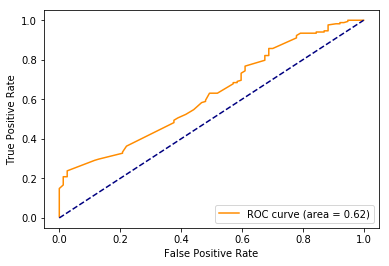

In [68]:
plt.plot(fpr, tpr, color = 'darkorange',
        label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

So after a lot of tinkering, I have a model that's about 70% accurate. That's about 6% more accurate than the initial model, so that's nothing to sneeze at. I explored a number of other avenues (such as upsampling the data to improve predictive power--this did not work well) that didn't end up making it into this final post. Sometimes the technique just flat didn't work and other times it simply didn't make much of a difference.  That is the nature of data science, however. There are a lot of techniques out there, and you have to know when to use each one. More importantly, you have to be willing to scrape something you put a lot of work into because it's just not useful. It's a frustrating, but important lesson to learn.

A couple final points of note. You may have noticed that while my accuracy improved, the AUROC(Area Under Receiver Operating Characteristic) did not. This is a more robust scoring metric that uses False Positive Rate and True Positive Rate to produce a more balanced view of your model performance. While accuracy flat out fails on data sets that are severely imbalanced (for instance, in medicine when dealing with rare diseases), AUC takes into consideration how many positive data points(in our case how a 'yes') were correctly identified as positive (also called TPR or Recall) and also how many negative data points('no's in our case) were incorrectly identified as positive ones. It's a little disappointing that AUROC didn't really improve, but I have a theory as to why that might be.

When training my models, there was quite a bit of variability when training the same model multiple times. This is really bad. It probably has to do with the amount of data I have, but basically it means I can't trust how good my model is. I could retrain it and get a result that's significantly different. I think given more data this problem would go away, but it's also possible that I'd need to go back to the drawing board and reassess how I'm modeling this data.

Just as quick, dirty test, I built the same model but using the full data set. I only have the oob score to evaluate with now, but the results seem pretty similar to the training/validation split. I can't be too unhappy with this quick analysis overall though. ~70% accuracy is decent for a couple hours of work. I'd love to hear how others are approaching this or similar problems. 

Thanks for reading!

In [69]:
df, y, nas = proc_df(modeling_df, "Attended")
m = RandomForestClassifier(min_samples_leaf = 5,
                           max_features='log2', n_jobs=-1, oob_score=True)
m.fit(df, y)
print("Training Acc:", round(m.score(df, y),5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

Training Acc: 0.7661
Out-of-Bag Acc: 0.66422


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
